In [1]:
!pip install ultralytics h5py opencv-python tqdm
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import h5py
import numpy as np
import cv2
import glob
import random
import shutil
import os
from tqdm import tqdm

# --- CONFIGURATION ---
SOURCE_DRIVE_PATH = '/content/drive/MyDrive/Colab Notebooks/brain_segmentation/BraTS2020_training_data/content/data/'
OUTPUT_BASE_DIR = "/content/datasets/brats_yolo_final_split"

# On prend 10 000 images pour être robuste (statistiquement significatif)
NUM_IMAGES = 10000

def normalize_channel(channel):
    if np.max(channel) == np.min(channel): return np.zeros_like(channel, dtype=np.uint8)
    norm = (channel - np.min(channel)) / (np.max(channel) - np.min(channel))
    return (norm * 255).astype(np.uint8)

def mask_to_polygons(mask, class_id):
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    polygons = []
    H, W = mask.shape
    for cnt in contours:
        if cv2.contourArea(cnt) > 20:
            cnt = cnt.flatten()
            relative_coords = []
            for i in range(0, len(cnt), 2):
                x = cnt[i] / W
                y = cnt[i+1] / H
                relative_coords.extend([x, y])
            polygons.append(f"{class_id} " + " ".join([f"{n:.6f}" for n in relative_coords]))
    return polygons

def prepare_dataset_strict_split():
    if os.path.exists(OUTPUT_BASE_DIR): shutil.rmtree(OUTPUT_BASE_DIR)

    # Création des 3 dossiers étanches
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(OUTPUT_BASE_DIR, 'images', split), exist_ok=True)
        os.makedirs(os.path.join(OUTPUT_BASE_DIR, 'labels', split), exist_ok=True)

    print("Listing des fichiers...")
    files = glob.glob(os.path.join(SOURCE_DRIVE_PATH, "*.h5"))

    if not files:
        print("❌ ERREUR : Aucun fichier trouvé. Vérifie le chemin du Drive !")
        return

    random.shuffle(files)
    files_to_process = files[:NUM_IMAGES]

    print(f"🚀 Conversion rigoureuse (Train/Val/Test) de {len(files_to_process)} images...")

    for file_path in tqdm(files_to_process):
        try:
            # --- SPLIT ---
            # 70% Train / 15% Val / 15% Test
            r = random.random()
            if r < 0.70: split = 'train'
            elif r < 0.85: split = 'val'
            else: split = 'test'

            base_name = os.path.splitext(os.path.basename(file_path))[0]

            with h5py.File(file_path, 'r') as f:
                img, mask = f['image'][:], f['mask'][:]

                # Fusion RGB
                img_rgb = np.dstack((
                    normalize_channel(img[:, :, 2]),
                    normalize_channel(img[:, :, 3]),
                    normalize_channel(img[:, :, 1])
                ))
                cv2.imwrite(f"{OUTPUT_BASE_DIR}/images/{split}/{base_name}.jpg", img_rgb)

                # Labels
                polys = []
                for ch in range(3):
                    if np.max(mask[:,:,ch]) > 0:
                        polys.extend(mask_to_polygons(mask[:,:,ch], ch))

                if polys:
                    with open(f"{OUTPUT_BASE_DIR}/labels/{split}/{base_name}.txt", 'w') as f:
                        f.write("\n".join(polys))
        except: pass

    # YAML
    yaml = f"""
path: {OUTPUT_BASE_DIR}
train: images/train
val: images/val
test:  images/test
names:
  0: necrose
  1: oedeme
  2: tumeur_active
"""
    with open(f"{OUTPUT_BASE_DIR}/data.yaml", "w") as f: f.write(yaml)
    print("\n✅ Dataset Prêt : Les données de Test sont isolées.")

prepare_dataset_strict_split()

Listing des fichiers...
🚀 Conversion rigoureuse (Train/Val/Test) de 10000 images...


100%|██████████| 10000/10000 [57:40<00:00,  2.89it/s]


✅ Dataset Prêt : Les données de Test sont isolées.


In [3]:
from ultralytics import YOLO

# Modèle Small (Meilleur compromis)
model = YOLO('yolo11s-seg.pt')

print("Entraînement en cours...")

results = model.train(
    data='/content/datasets/brats_yolo_final_split/data.yaml',
    epochs=50,
    patience=10,
    imgsz=512,
    batch=16,
    name='brats_rigorous_run',
    device=0
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Entraînement en cours...
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/brats_yolo_final_split/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=

In [4]:
print("👨‍🔬 L'HEURE DE VÉRITÉ : Validation sur le JEU DE TEST...")

# Charger le modèle qu'on vient d'entraîner
# (Normalement le dossier sera brats_rigorous_run)
model = YOLO('/content/runs/segment/brats_rigorous_run/weights/best.pt')

# Lancer l'évaluation sur le split 'test'
metrics = model.val(split='test')

print("\n--- NOTES (Test Set) ---")
print(f"mAP50-95 (Note Globale) : {metrics.box.map:.4f}")
print("-" * 30)

👨‍🔬 L'HEURE DE VÉRITÉ : Validation sur le JEU DE TEST...
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s-seg summary (fused): 113 layers, 10,067,977 parameters, 0 gradients, 32.8 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4.1±3.6 MB/s, size: 8.7 KB)
val: Scanning /content/datasets/brats_yolo_final_split/labels/test... 628 images, 919 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1547/1547 642.9it/s 2.4s
val: New cache created: /content/datasets/brats_yolo_final_split/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 4.6it/s 20.9s
                   all       1547       1906      0.798      0.599      0.683      0.432      0.765       0.58      0.633      0.307
               necrose        351        440       0.78      0.593      0.658      0.407      0.766      0.587       0.63      0.347
                oed

✅ Tumeur détectée (Test Set) : volume_34_slice_83.jpg


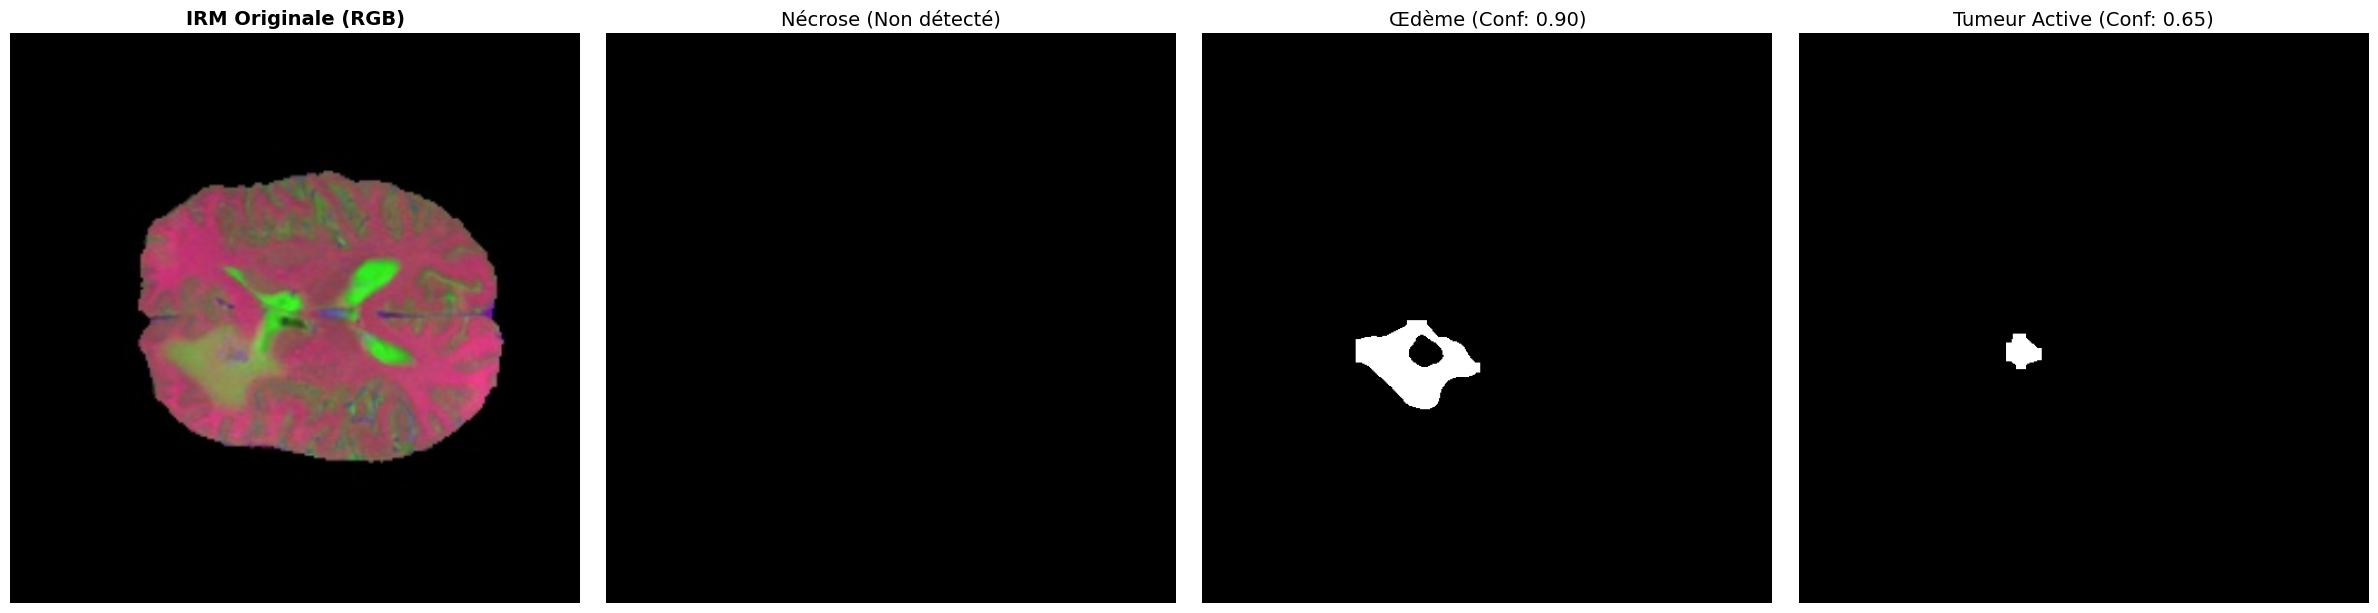

In [8]:
import matplotlib.pyplot as plt
import cv2
import glob
import random
import os
import numpy as np

# On pointe vers les images de TEST
DATA_PATH = '/content/datasets/brats_yolo_final_split/images/test/*.jpg'
val_images = glob.glob(DATA_PATH)

if len(val_images) > 0:
    found_tumor = False
    attempt = 0
    while not found_tumor and attempt < 50:
        attempt += 1
        test_img = random.choice(val_images)
        results = model.predict(test_img, conf=0.25, verbose=False)

        if results[0].masks is not None:
            found_tumor = True
            print(f"✅ Tumeur détectée (Test Set) : {os.path.basename(test_img)}")

            masks_data = results[0].masks.data.cpu().numpy()
            class_indices = results[0].boxes.cls.cpu().numpy()
            conf_scores = results[0].boxes.conf.cpu().numpy()

            h, w = masks_data.shape[1], masks_data.shape[2]
            semantic_maps = {0: np.zeros((h, w)), 1: np.zeros((h, w)), 2: np.zeros((h, w))}
            class_scores = {0: [], 1: [], 2: []}

            for mask, cls, score in zip(masks_data, class_indices, conf_scores):
                semantic_maps[int(cls)] = np.maximum(semantic_maps[int(cls)], mask)
                class_scores[int(cls)].append(score)

            fig, ax = plt.subplots(1, 4, figsize=(24, 6))
            orig = cv2.resize(cv2.imread(test_img), (w, h))
            ax[0].imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
            ax[0].set_title("IRM Originale (RGB)", fontsize=14, fontweight='bold')

            titles = {0: "Nécrose", 1: "Œdème", 2: "Tumeur Active"}
            for i in range(3):
                score_txt = f" (Conf: {max(class_scores[i]):.2f})" if class_scores[i] else " (Non détecté)"
                ax[i+1].imshow(semantic_maps[i], cmap='gray')
                ax[i+1].set_title(f"{titles[i]}{score_txt}", fontsize=14)

            for a in ax: a.axis('off')
            plt.tight_layout()
            plt.show()
else:
    print("❌ Pas d'images trouvées.")

In [6]:
import shutil, os, glob
from datetime import datetime

runs = sorted(glob.glob("/content/runs/segment/brats_rigorous_run*"))
if runs:
    best_weight = os.path.join(runs[-1], "weights/best.pt")
    backup_path = "/content/drive/MyDrive/Colab Notebooks/brain_segmentation/final_models/"
    os.makedirs(backup_path, exist_ok=True)

    timestamp = datetime.now().strftime("%Y-%m-%d_%Hh%M")
    dest = os.path.join(backup_path, f"FINAL_BEST_MODEL_{timestamp}.pt")
    shutil.copy(best_weight, dest)
    print(f"✅ Modèle sauvegardé : {dest}")

✅ Modèle sauvegardé : /content/drive/MyDrive/Colab Notebooks/brain_segmentation/final_models/FINAL_BEST_MODEL_2025-12-04_12h47.pt


✅ Modèle chargé.
📊 Génération du Dashboard pour : volume_265_slice_103.h5


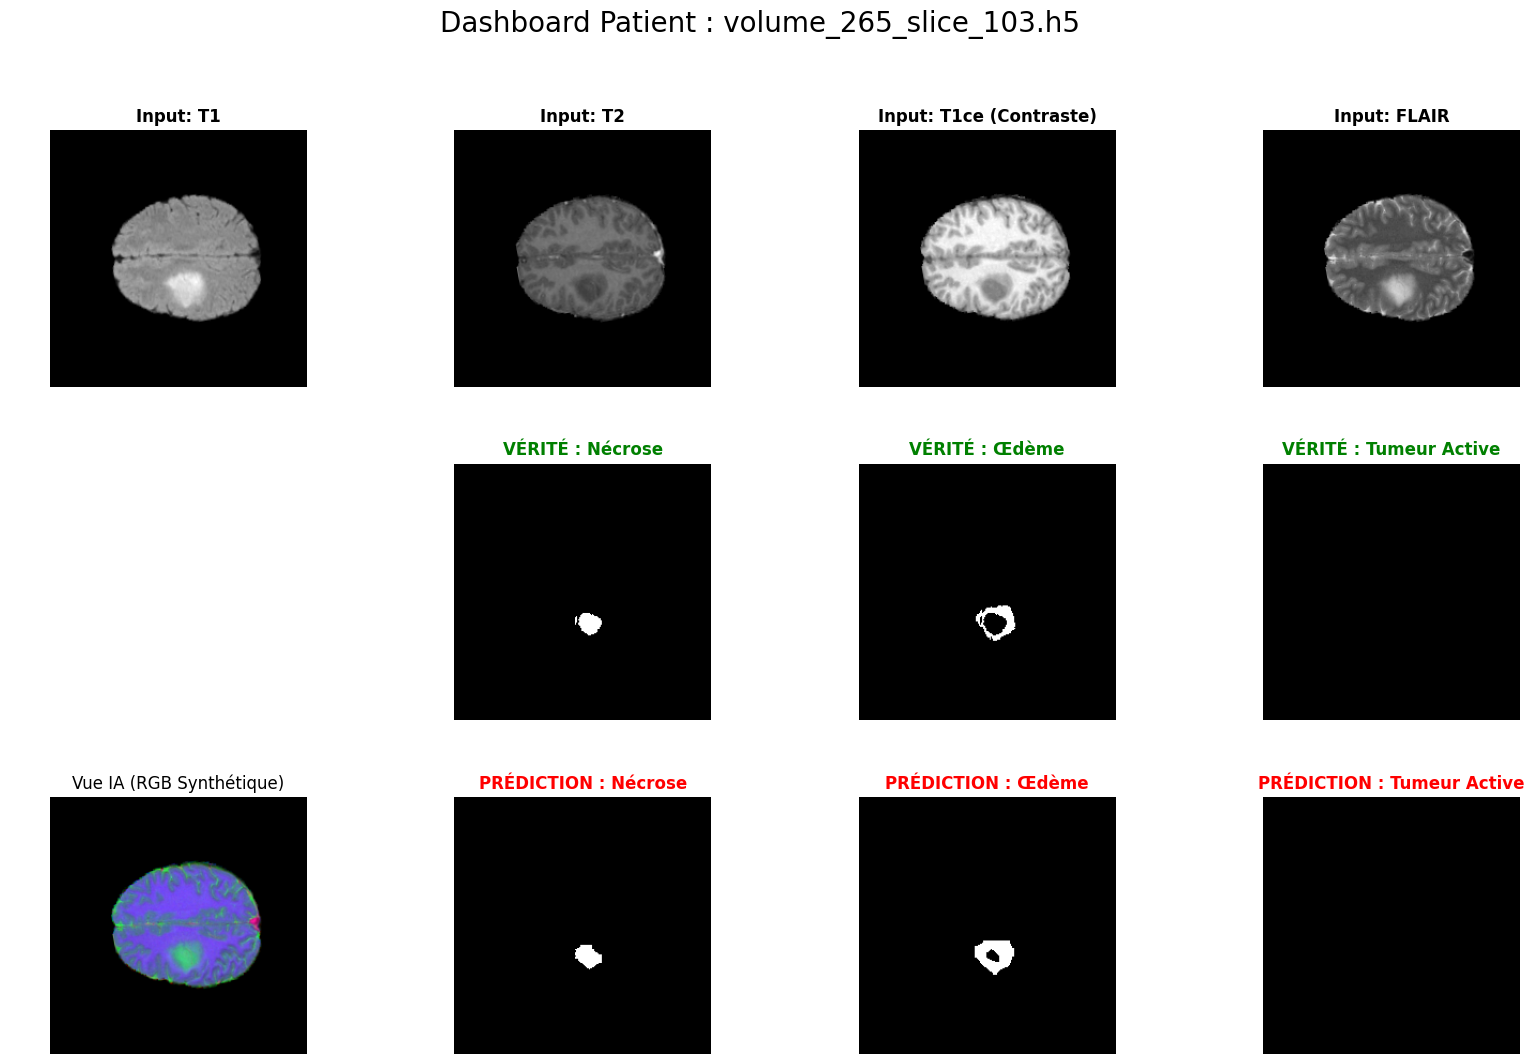

📊 Génération du Dashboard pour : volume_199_slice_108.h5


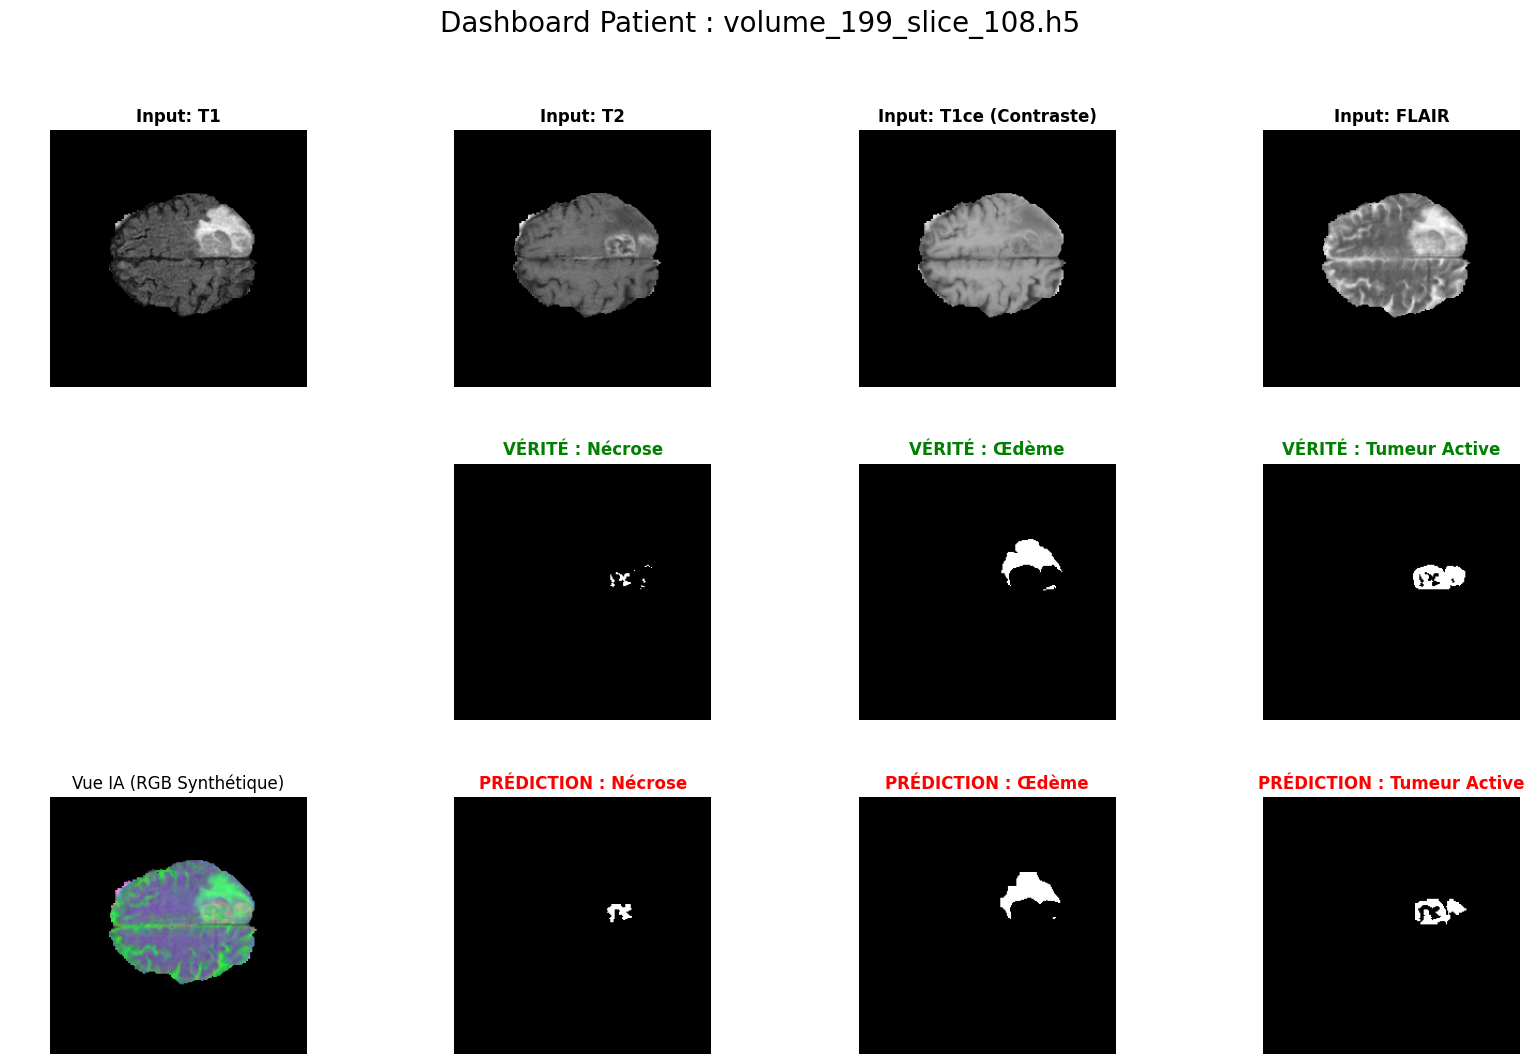

📊 Génération du Dashboard pour : volume_180_slice_60.h5


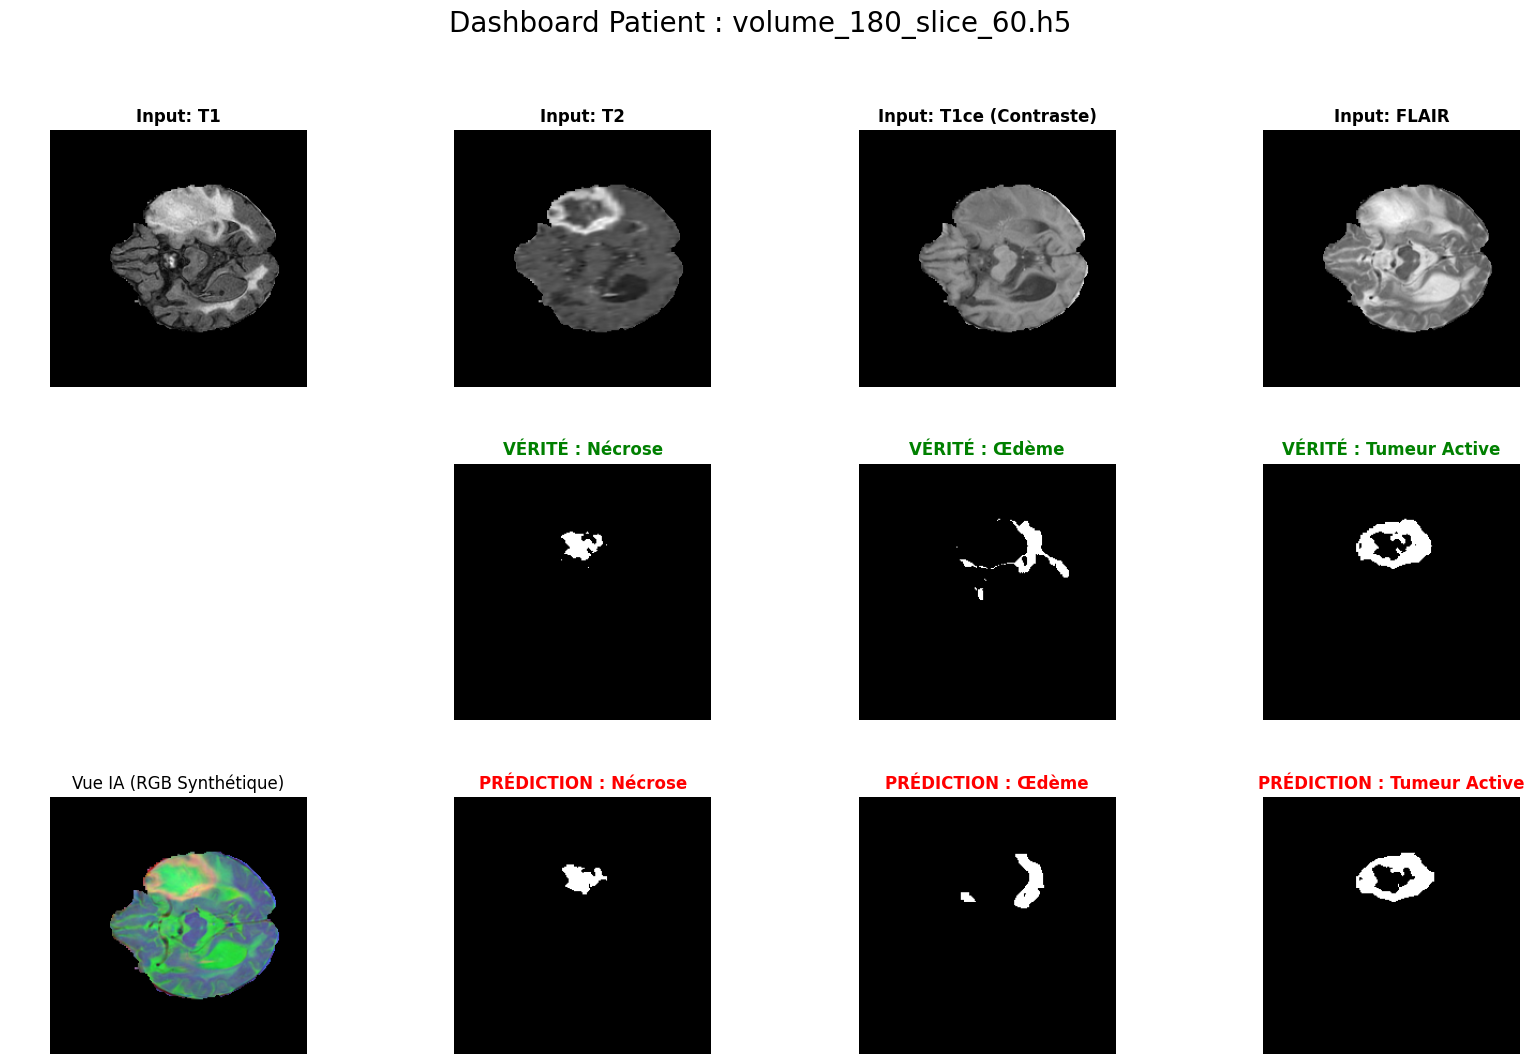

In [10]:
import h5py
import matplotlib.pyplot as plt
import cv2
import os
import glob
import numpy as np
from ultralytics import YOLO
import random

# --- CONFIGURATION ---
# 1. Chemin vers tes fichiers H5 originaux (Sur le Drive)
# C'est là qu'on va chercher les T1, T2, etc.
H5_SOURCE_PATH = "/content/drive/MyDrive/Colab Notebooks/brain_segmentation/BraTS2020_training_data/content/data/"

# 2. Chemin vers ton meilleur modèle
# Vérifie que c'est bien le bon dossier (brats_rigorous_run ou final_small2 ?)
MODEL_PATH = '/content/runs/segment/brats_rigorous_run/weights/best.pt'

# Charger le modèle
if os.path.exists(MODEL_PATH):
    model = YOLO(MODEL_PATH)
    print("✅ Modèle chargé.")
else:
    print("❌ Erreur de chemin modèle.")

def visualize_supervisor_dashboard(h5_path):
    filename = os.path.basename(h5_path)
    print(f"📊 Génération du Dashboard pour : {filename}")

    with h5py.File(h5_path, 'r') as f:
        # --- A. LES ENTRÉES (INPUTS) ---
        # BraTS est souvent : 0:T1, 1:T1ce, 2:T2, 3:FLAIR
        vol = f['image'][:]
        t1 = vol[:,:,0]
        t1ce = vol[:,:,1]
        t2 = vol[:,:,2]
        flair = vol[:,:,3]

        # --- B. LA VÉRITÉ TERRAIN (GROUND TRUTH) ---
        # 0:Nécrose, 1:Œdème, 2:Tumeur Active
        mask = f['mask'][:]
        gt_necrose = mask[:,:,0]
        gt_oedeme = mask[:,:,1]
        gt_tumeur = mask[:,:,2]

        # --- C. LA PRÉDICTION YOLO ---
        # On doit recuisiner l'image RGB pour l'IA
        def norm(x):
            if np.max(x) == np.min(x): return np.zeros_like(x, dtype=np.uint8)
            n = (x - np.min(x)) / (np.max(x) - np.min(x))
            return (n * 255).astype(np.uint8)

        # Rappel de ta recette : R=T1ce, G=FLAIR, B=T2
        img_rgb = np.dstack((norm(t2), norm(flair), norm(t1ce)))

        # Prédiction
        results = model.predict(img_rgb, conf=0.25, verbose=False)

        # Reconstruction des masques prédits
        h, w = 240, 240
        pred_map = {0: np.zeros((h,w)), 1: np.zeros((h,w)), 2: np.zeros((h,w))}

        if results[0].masks is not None:
            data = results[0].masks.data.cpu().numpy()
            cls = results[0].boxes.cls.cpu().numpy()
            for m, c in zip(data, cls):
                # YOLO resize parfois à 512, on remet en 240 pour comparer
                m_resized = cv2.resize(m, (w, h))
                pred_map[int(c)] = np.maximum(pred_map[int(c)], m_resized)

    # --- D. AFFICHAGE (Le Format demandé) ---
    # 3 Lignes : Inputs / Vérité / Prédiction
    fig, ax = plt.subplots(3, 4, figsize=(20, 12))
    plt.subplots_adjust(hspace=0.3)

    # LIGNE 1 : Les 4 Canaux Bruts (Ce que voit le médecin)
    ax[0,0].imshow(t1, cmap='gray'); ax[0,0].set_title("Input: T1", fontweight='bold')
    ax[0,1].imshow(t2, cmap='gray'); ax[0,1].set_title("Input: T2", fontweight='bold')
    ax[0,2].imshow(t1ce, cmap='gray'); ax[0,2].set_title("Input: T1ce (Contraste)", fontweight='bold')
    ax[0,3].imshow(flair, cmap='gray'); ax[0,3].set_title("Input: FLAIR", fontweight='bold')

    # LIGNE 2 : La Vérité Terrain (Ce que le médecin a tracé)
    ax[1,0].axis('off') # Case vide pour aligner
    ax[1,1].imshow(gt_necrose, cmap='gray'); ax[1,1].set_title("VÉRITÉ : Nécrose", color='green', fontweight='bold')
    ax[1,2].imshow(gt_oedeme, cmap='gray'); ax[1,2].set_title("VÉRITÉ : Œdème", color='green', fontweight='bold')
    ax[1,3].imshow(gt_tumeur, cmap='gray'); ax[1,3].set_title("VÉRITÉ : Tumeur Active", color='green', fontweight='bold')

    # LIGNE 3 : La Prédiction YOLO (Ce que l'IA a trouvé)
    ax[2,0].imshow(img_rgb); ax[2,0].set_title("Vue IA (RGB Synthétique)")
    ax[2,1].imshow(pred_map[0], cmap='gray'); ax[2,1].set_title("PRÉDICTION : Nécrose", color='red', fontweight='bold')
    ax[2,2].imshow(pred_map[1], cmap='gray'); ax[2,2].set_title("PRÉDICTION : Œdème", color='red', fontweight='bold')
    ax[2,3].imshow(pred_map[2], cmap='gray'); ax[2,3].set_title("PRÉDICTION : Tumeur Active", color='red', fontweight='bold')

    # Nettoyage des axes
    for a in ax.flat: a.axis('off')

    plt.suptitle(f"Dashboard Patient : {filename}", fontsize=20)
    plt.show()

# --- LANCEMENT AUTOMATIQUE ---
# On cherche un fichier au hasard qui contient une tumeur (pour que ce soit intéressant)
all_h5 = glob.glob(os.path.join(H5_SOURCE_PATH, "*.h5"))
random.shuffle(all_h5)

found = 0
for h5 in all_h5:
    if found >= 3: break # On affiche 3 exemples
    try:
        with h5py.File(h5, 'r') as f:
            # On vérifie s'il y a quelque chose à voir (masque non vide)
            if np.max(f['mask'][:]) > 0:
                visualize_supervisor_dashboard(h5)
                found += 1
    except: pass